# Load the master table

In [1]:
from vulnerable_populations.pipeline import Granularity

granularity = Granularity.COUNTY_LEVEL

In [2]:
covid_19_master = catalog.load(f"mod_covid_19_{granularity.value}_master")
covid_19_master

2020-06-15 01:28:33,503 - kedro.io.data_catalog - INFO - Loading data from `mod_covid_19_county_level_master` (ParquetDataSet)...


,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,49055,Wayne,Utah,UT,2690.0,0.0,0.0,0.0,0.0,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,All,21091,Hancock,Kentucky,KY,8758.0,0.0,7.0,0.0,79.0,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,All,27077,Lake of the Woods,Minnesota,MN,3758.0,0.0,0.0,0.0,0.0,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,All,19129,Mills,Iowa,IA,15063.0,0.0,22.0,0.0,146.0,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,All,49033,Rich,Utah,UT,2464.0,0.0,0.0,0.0,0.0,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,All,22007,Assumption Parish,Louisiana,LA,22300.0,14.0,258.0,62.0,1156.0,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,All,27093,Meeker,Minnesota,MN,23141.0,1.0,50.0,4.0,216.0,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,All,37033,Caswell,North Carolina,NC,22698.0,1.0,101.0,4.0,444.0,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,All,51053,Dinwiddie,Virginia,VA,28529.0,0.0,101.0,0.0,354.0,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


In [3]:
from datetime import datetime

from kedro.io.core import VERSION_FORMAT

last_load_version = datetime.strptime(
    getattr(
        catalog.datasets, f"raw_csbh_{granularity.value}_data"
    ).resolve_load_version(),
    VERSION_FORMAT,
)
print(
    "Center for Societal Benefit through Healthcare, McKinsey & Company. "
    "Vulnerable Populations Dashboard. https://csbh-dashboard.mckinsey.digital/#/. "
    f"Accessed on {last_load_version.date()}."
)

Center for Societal Benefit through Healthcare, McKinsey & Company. Vulnerable Populations Dashboard. https://csbh-dashboard.mckinsey.digital/#/. Accessed on 2020-06-13.


# Plot a diagonal correlation matrix

Adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html.

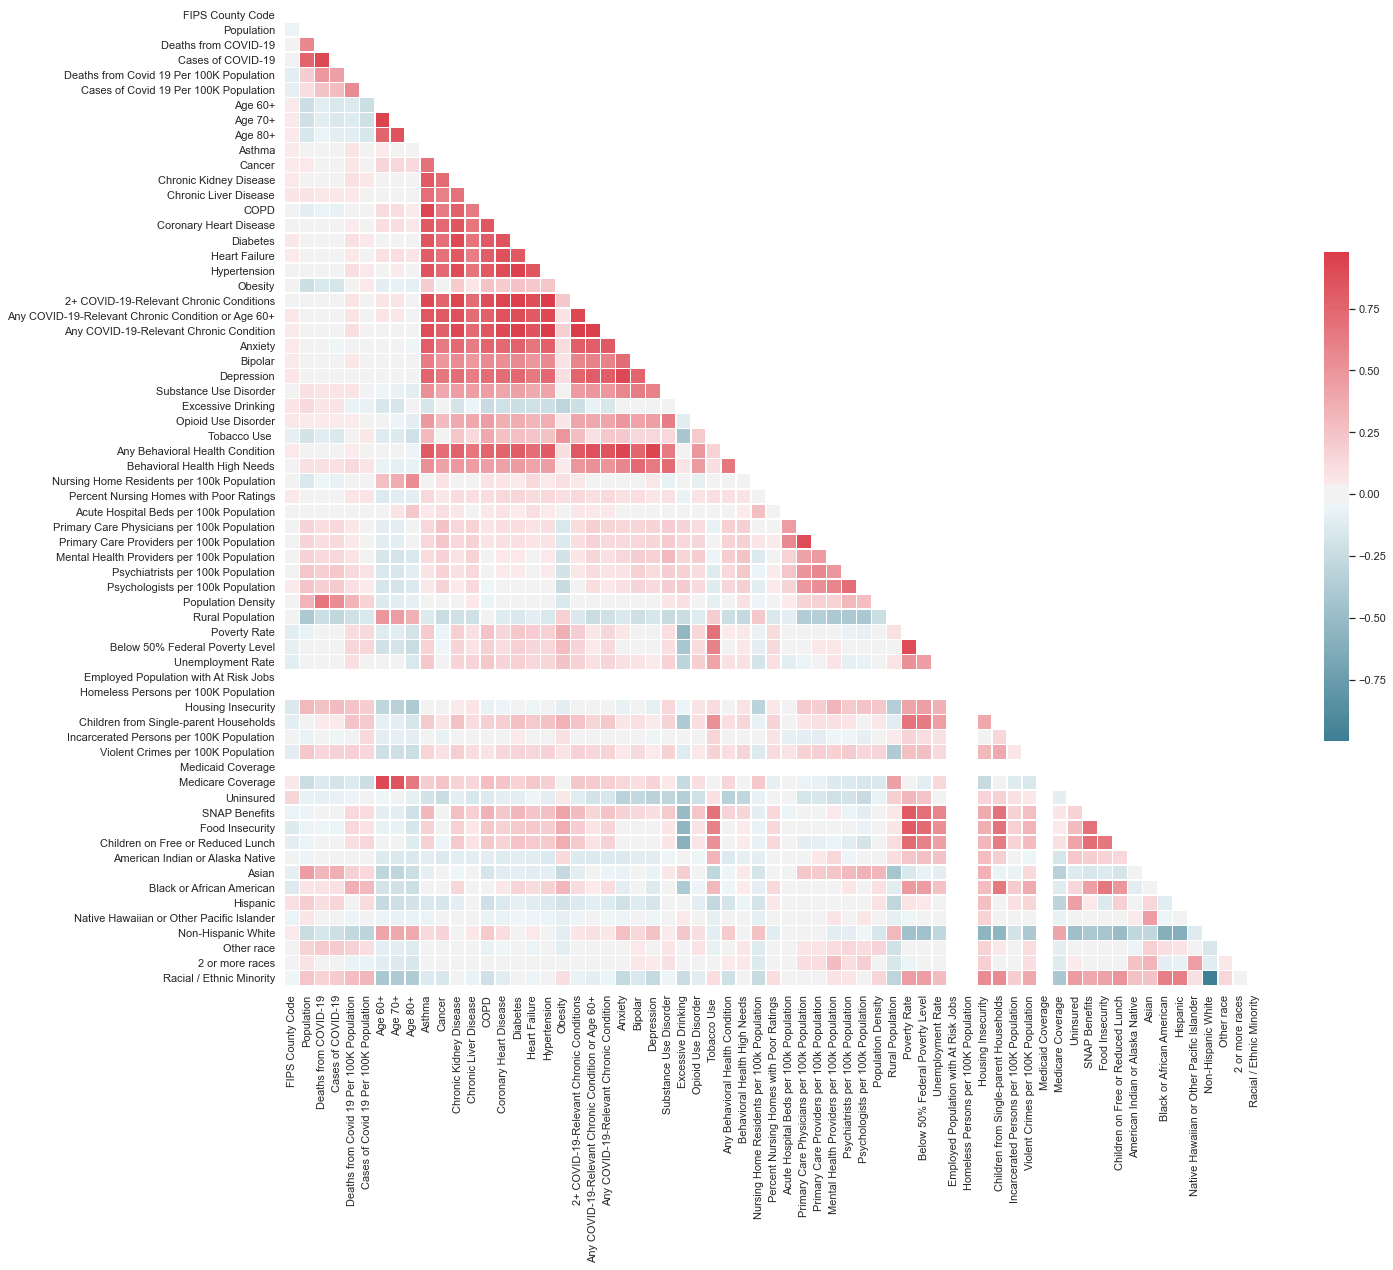

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = covid_19_master.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Split master table into feature matrix and selected target array

In [5]:
from enum import Enum


class Target(Enum):
    DEATHS = "Deaths from Covid 19 Per 100K Population"
    CASES = "Cases of Covid 19 Per 100K Population"

In [6]:
X = covid_19_master.loc[:, "Age 60+":]
y = covid_19_master[Target.CASES.value]
display(X, y)

,Age 60+,Age 70+,Age 80+,Asthma,Cancer,Chronic Kidney Disease,Chronic Liver Disease,COPD,Coronary Heart Disease,Diabetes,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,0.282,0.138,0.036,0.026,0.026,0.018,0.009,0.018,0.019,0.029,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,0.229,0.111,0.032,0.038,0.019,0.044,0.011,0.035,0.065,0.084,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,0.320,0.142,0.053,0.045,0.019,0.038,0.006,0.045,0.064,0.064,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,0.248,0.108,0.043,0.046,0.028,0.056,0.009,0.041,0.075,0.088,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,0.237,0.125,0.040,0.046,0.009,0.028,0.009,0.019,0.019,0.037,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,0.235,0.108,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,0.267,0.132,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,0.276,0.138,0.049,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,0.229,0.104,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


0          0.0
1         79.0
2          0.0
3        146.0
4          0.0
         ...  
3133    1156.0
3134     216.0
3135     444.0
3136     354.0
3137     324.0
Name: Cases of Covid 19 Per 100K Population, Length: 3138, dtype: float64

# Visualize feature importances

Adapted from https://github.com/slundberg/shap#tree-ensemble-example-with-treeexplainer-xgboostlightgbmcatboostscikit-learnpyspark-models.

In [7]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


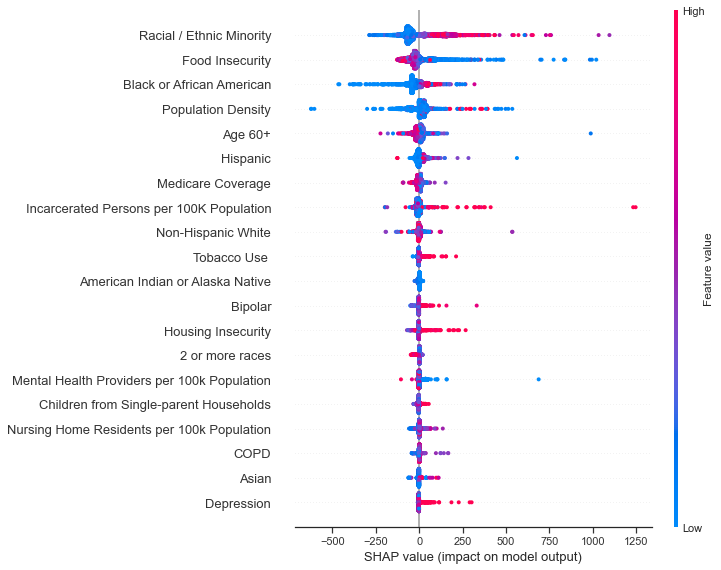

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

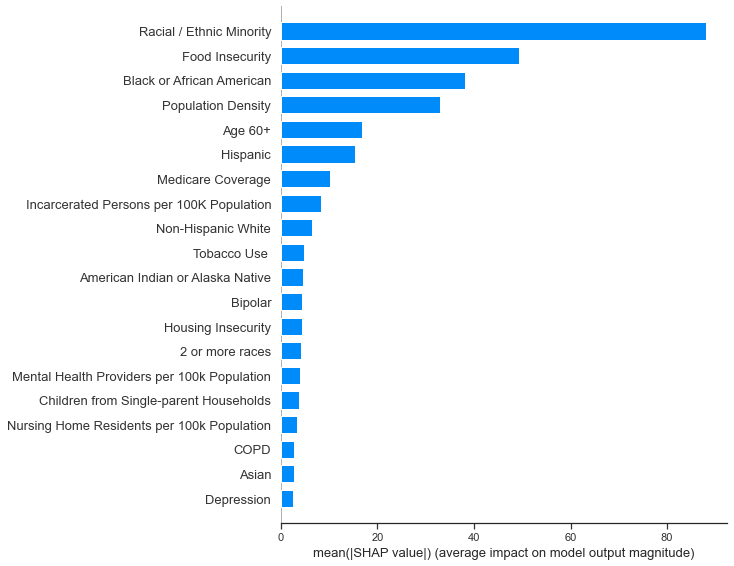

In [9]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Engineer and eliminate features

### Age

In [10]:
X["Age 60+"] -= X["Age 70+"]
X["Age 70+"] -= X["Age 80+"]
X.rename(columns={"Age 60+": "Age 60-69", "Age 70+": "Age 70-79"}, inplace=True)

### Chronic Conditions

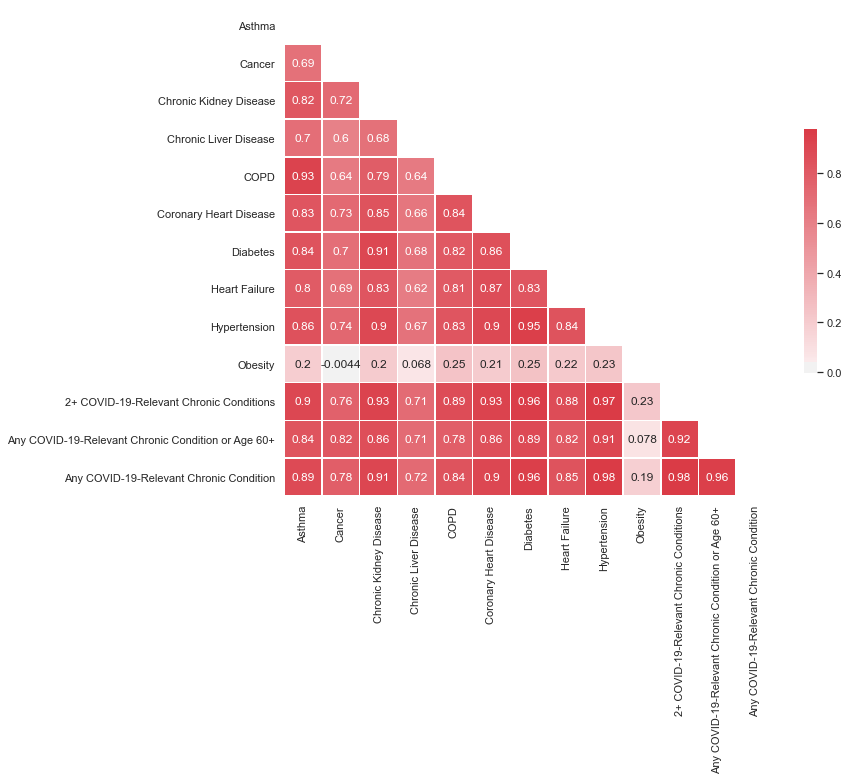

In [11]:
# Subset the correlation matrix
chronic_conditions_corr = covid_19_master.corr().loc[
    "Asthma":"Any COVID-19-Relevant Chronic Condition",
    "Asthma":"Any COVID-19-Relevant Chronic Condition",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(chronic_conditions_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chronic_conditions_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
X.drop(
    columns=[
        "2+ COVID-19-Relevant Chronic Conditions",
        "Any COVID-19-Relevant Chronic Condition or Age 60+",
        "Any COVID-19-Relevant Chronic Condition",
    ],
    inplace=True,
)

### Behavioral Health

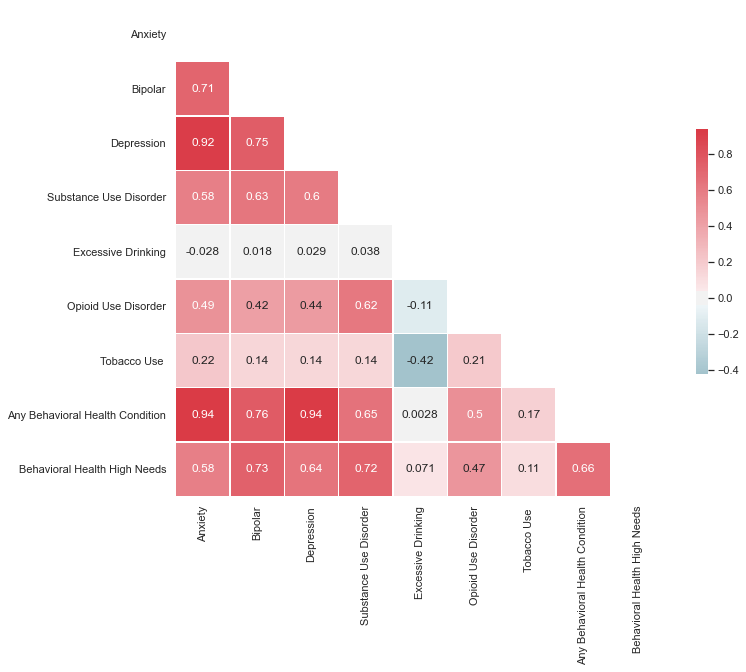

In [13]:
# Subset the correlation matrix
behavioral_health_corr = covid_19_master.corr().loc[
    "Anxiety":"Behavioral Health High Needs",
    "Anxiety":"Behavioral Health High Needs",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(behavioral_health_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(behavioral_health_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
X.drop(columns="Any Behavioral Health Condition", inplace=True)

### Healthcare Supply

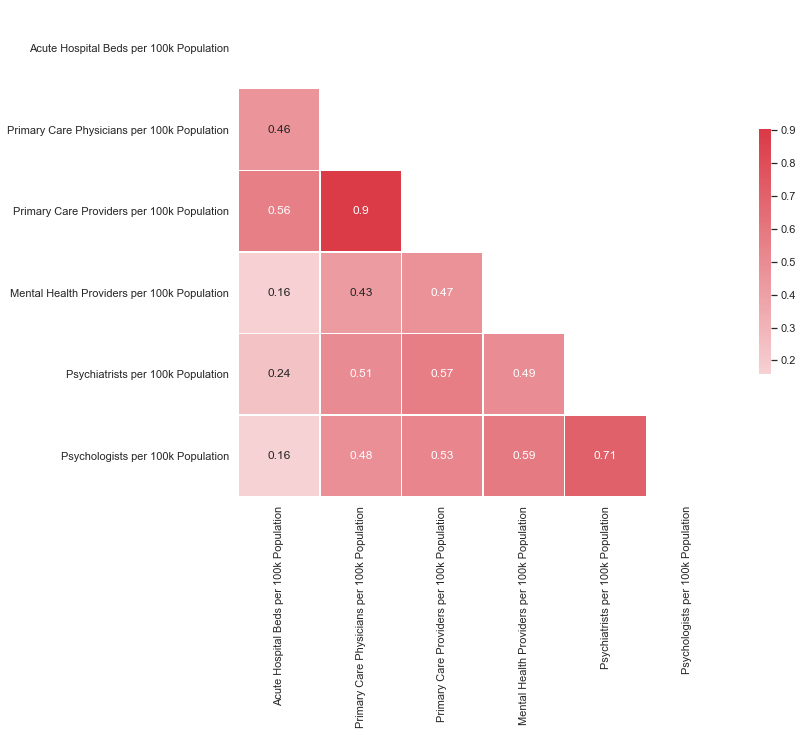

In [15]:
# Subset the correlation matrix
healthcare_supply_corr = covid_19_master.corr().loc[
    "Acute Hospital Beds per 100k Population":"Psychologists per 100k Population",
    "Acute Hospital Beds per 100k Population":"Psychologists per 100k Population",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(healthcare_supply_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(healthcare_supply_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
X["Primary Care Providers per 100k Population"] -= X[
    "Primary Care Physicians per 100k Population"
]
X.rename(
    columns={
        "Primary Care Providers per 100k Population": "Primary Care Mid-Level Providers per 100k Population"
    },
    inplace=True,
)

### Social / Community Factors

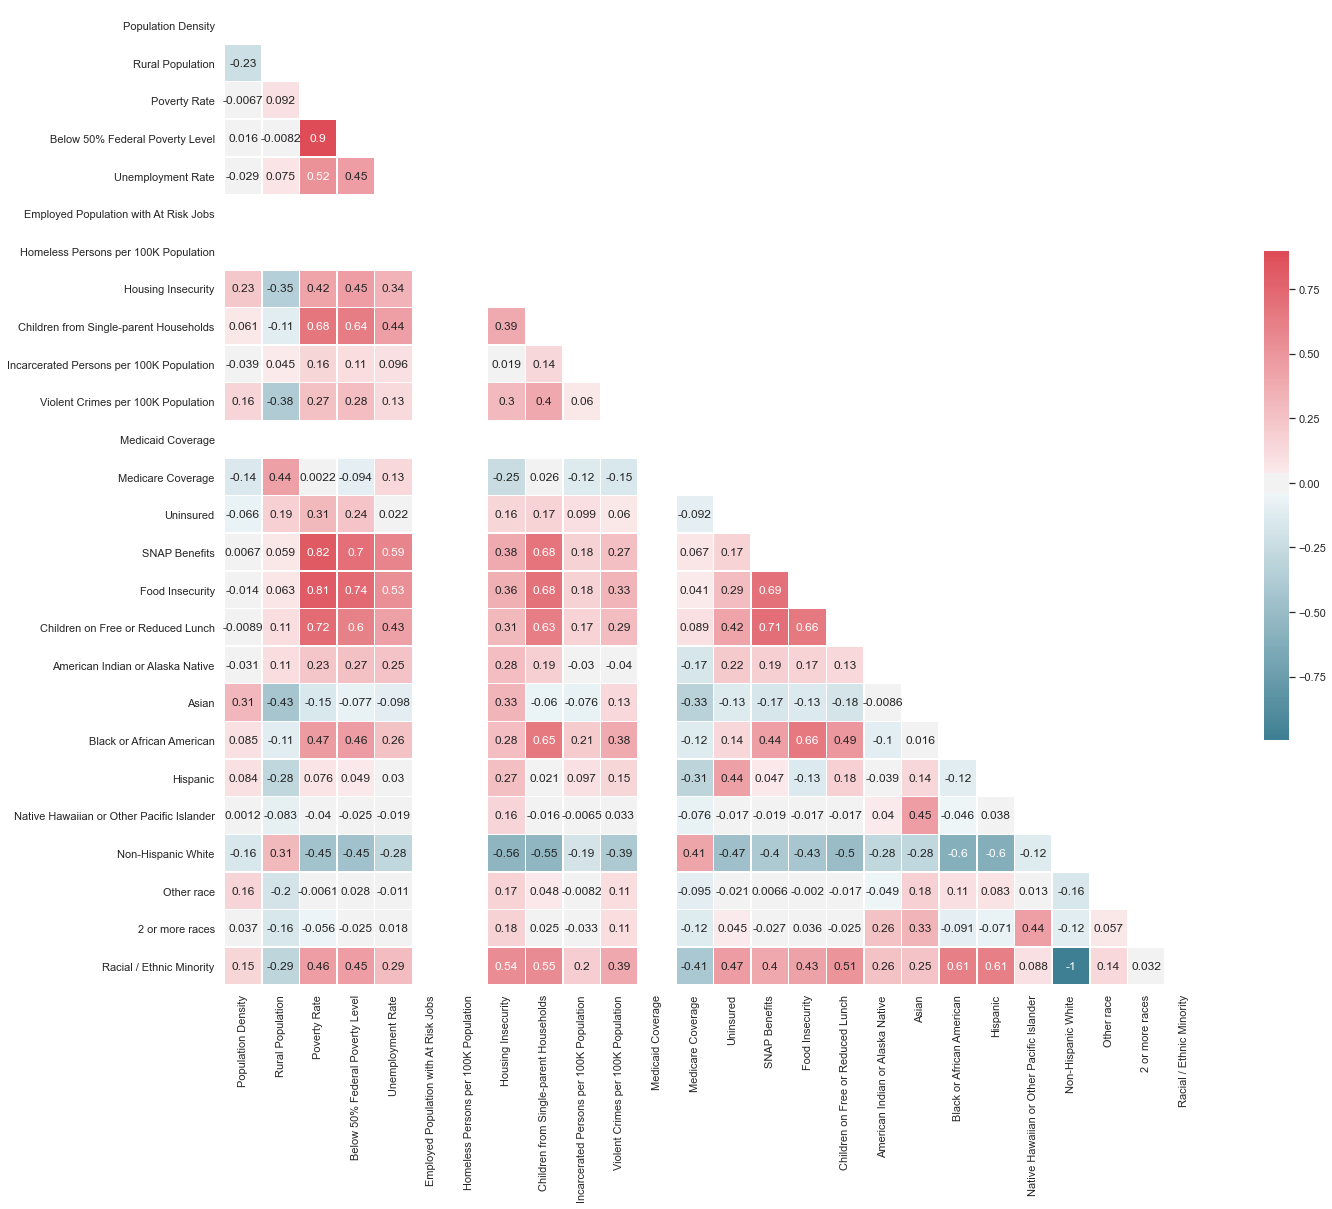

In [17]:
# Subset the correlation matrix
social_community_factors_corr = covid_19_master.corr().loc[
    "Population Density":, "Population Density":
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(social_community_factors_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(social_community_factors_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
X["Poverty Rate"] -= X["Below 50% Federal Poverty Level"]
X.rename(
    columns={"Poverty Rate": "50-100% Federal Poverty Level"}, inplace=True,
)

In [19]:
X.drop(
    columns=["SNAP Benefits", "Food Insecurity", "Children on Free or Reduced Lunch"],
    inplace=True,
)

In [20]:
X.drop(columns="Racial / Ethnic Minority", inplace=True)

# Visualize feature importances (again!)

In [21]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

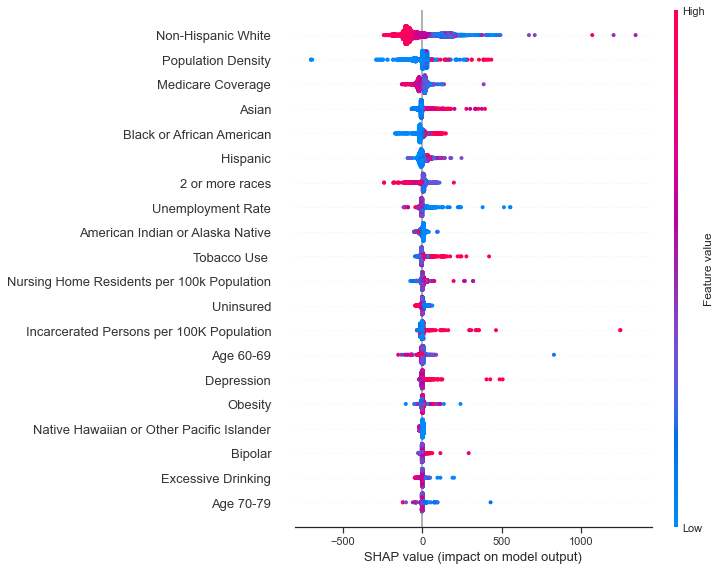

In [22]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

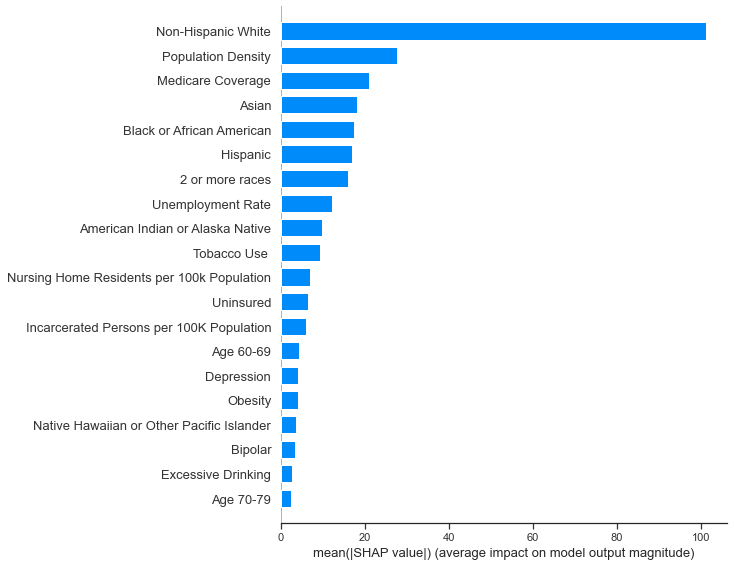

In [23]:
shap.summary_plot(shap_values, X, plot_type="bar")